# Sparsemax

sparsemax 정리, 만드는 과정을 요약하면 tau(임계점)을 지정하고 그 값을 넘지 못하는 값은 0으로 만든다. tau의 value와 X에서 몇 개를 선택할 것인지(support_size)를 최적화시키는 것이 목적이고 tau 값은 X(기존 logit값)에서 만들어진다.

1. X(logits) 값에서 가장 큰 값을 빼주어 스케일링을 한 후 ;(애초에 logits 값에서 가장 큰 값을 기준으로 모두 빼주므로) 가장 큰 값에서 차이가 많았던 값들은 차이가 큰 음수 값으로 보내진다.
2. 스케일링 된 값들은 위치로 만들어진 가중치들과 곱해져서 축적합과 비교된 후, dim기준으로 축적합을 넘지 못하는 값은 False로 반환
3. 잘려진 축적합에 support_size를 나눠주면 tau가 정해진다.
4. tau와 스케일링 된 logits값을 비교해서 작은 것은 0으로 나머지는 보존.



In [1]:
import torch
import torch.nn as nn
from torch.autograd import Function

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# 
X = torch.rand(1,1,200,200)
dim=-1


In [3]:
X

tensor([[[[0.8054, 0.5984, 0.1366,  ..., 0.8235, 0.5326, 0.0519],
          [1.0000, 0.9807, 0.2148,  ..., 0.2384, 0.1162, 0.0620],
          [0.0760, 0.8849, 0.7447,  ..., 0.0352, 0.2145, 0.9048],
          ...,
          [0.5857, 0.2035, 0.2517,  ..., 0.2025, 0.6658, 0.2929],
          [0.1201, 0.4569, 0.7379,  ..., 0.5866, 0.2660, 0.5805],
          [0.2429, 0.8839, 0.8786,  ..., 0.0426, 0.5198, 0.6310]]]])

In [59]:
rhos = _make_ix_like(X,dim=dim)

In [11]:
tau, support_size = _sparsemax_threshold_and_support(X) 

<BarContainer object of 200 artists>

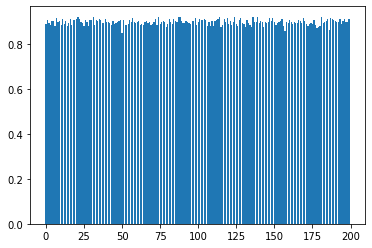

In [110]:
plt.bar(np.arange(tau.shape[2]),tau[0,0,:,:].permute(1,0).squeeze(), align='center')

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  4.,  1.,
         9.,  7., 12., 12.,  7., 13., 15., 23., 21., 10., 10., 12., 15.,
         5.,  8.,  3.,  7.]),
 array([0.848301  , 0.8507566 , 0.85321224, 0.8556678 , 0.8581235 ,
        0.8605791 , 0.86303467, 0.8654903 , 0.8679459 , 0.87040156,
        0.87285715, 0.87531275, 0.8777684 , 0.880224  , 0.88267964,
        0.88513523, 0.8875908 , 0.8900465 , 0.89250207, 0.8949577 ,
        0.8974133 , 0.8998689 , 0.90232456, 0.90478015, 0.9072358 ,
        0.9096914 , 0.912147  , 0.91460264, 0.9170582 , 0.9195139 ,
        0.9219695 ], dtype=float32),
 <a list of 30 Patch objects>)

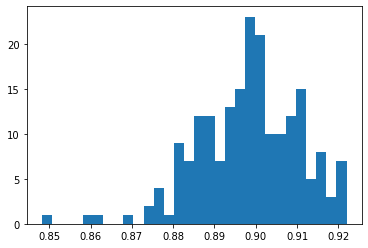

In [115]:
x =tau[0,0,:,:].permute(1,0).squeeze()
plt.hist(x, bins=30)

In [116]:
def _make_ix_like(X,dim):
    d = X.size(dim)
    rho = torch.arange(1,d+1,device=X.device, dtype=X.dtype)
    view = [1]*X.dim()
    view[0] = -1
    return rho.view(view).transpose(0,dim)


def _sparsemax_threshold_and_support(X, dim=-1, k=None):
    
    if k is None or k >= X.shape[dim]:  # do full sort
        # descending, values & indexes
        topk, _ = torch.sort(X, dim=dim, descending=True)
    else:
        topk, _ = torch.topk(X, k=k, dim=dim)
    
    print("topk", topk)
    topk_cumsum = topk.cumsum(dim) - 1
    # [[[[1,2,3,4,5]]]] => size: X.dim() , 1,1,1,X.size(dim=-1)
    rhos = _make_ix_like(topk, dim)
    print("rhos", rhos)
    print("rhos*topk", rhos*topk)
    print("topk_cumsum",topk_cumsum)
    
    # bool sum => int 
     # rhos는 각 row마다 위치분포를 나타냄
     # topk는 X의 큰->작은 분포로 변환
     # topk cumsum은 뒤로 갈수록 작->큰 분포로 변환 
     # row의 분포들을 바꾸는데
    support = rhos * topk > topk_cumsum
    print("support", support)
    # 넘는 것들만 카운트해서 숫자를 row마다 1개씩 반환 (인덱스 역할)
    support_size = support.sum(dim=dim).unsqueeze(dim)
    print("support_size",support_size)
    # topk_cumsum에서 경계선을 가름
    tau = topk_cumsum.gather(dim, support_size - 1)
    print("tau1",tau)
    # [1,1,200,1]
    tau /= support_size.to(X.dtype)
    print("tau2",tau)
    if k is not None and k < X.shape[dim]:
        unsolved = (support_size == k).squeeze(dim)

        if torch.any(unsolved):
            in_ = _roll_last(X, dim)[unsolved]
            tau_, ss_ = _sparsemax_threshold_and_support(in_, dim=-1, k=2 * k)
            _roll_last(tau, dim)[unsolved] = tau_
            _roll_last(support_size, dim)[unsolved] = ss_

    return tau, support_size

class SparsemaxFunction(Function):
    @classmethod
    def forward(cls, ctx, X, dim=-1, k=None):
        """
        ctx : 역전파 연산을 위한 정보 저장 object
        """
        ctx.dim = dim
        # max_val : column max 1 
        max_val, _ = X.max(dim=dim, keepdim=True)
        X = X - max_val  # same numerical stability trick as softmax
        print("X", X)
        tau, supp_size = _sparsemax_threshold_and_support(X, dim=dim, k=k)
        # z -tau
        output = torch.clamp(X - tau, min=0)
        # backward
        ctx.save_for_backward(supp_size, output)
        return output

    @classmethod
    def backward(cls, ctx, grad_output):
        supp_size, output = ctx.saved_tensors
        dim = ctx.dim
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = grad_input.sum(dim=dim) / supp_size.to(output.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)
        grad_input = torch.where(output != 0, grad_input - v_hat, grad_input)
        return grad_input, None, None

def sparsemax(X,dim=-1,k=None):
    return SparsemaxFunction.apply(X,dim,k)

In [101]:
x_ = torch.randn(10,10)

In [109]:
k = np.random.randint(10)

In [110]:
x_[k] = x_[k]*8

In [111]:
x_

tensor([[-1.1396e+00,  2.3982e-01, -7.9729e-01,  2.6914e-01,  2.6597e-01,
          8.8505e-01, -9.2974e-01, -6.8355e-01, -6.9846e-01,  9.1334e-01],
        [ 2.5854e-01,  4.1953e-01,  1.2562e-01,  1.4634e+00,  2.3153e-01,
         -1.0106e-01,  3.8992e-01,  3.8638e-01,  5.9428e-01, -1.6422e+00],
        [ 1.8960e+00,  7.6914e-02, -2.4006e-01, -1.2993e+00, -5.8890e-01,
          2.2636e+00, -1.8875e-01, -1.3250e+00, -4.1252e-01,  1.9590e+00],
        [-3.2919e-01, -1.4407e+00, -7.6573e-01,  1.6542e+00, -1.2928e+00,
          1.5508e+00,  1.6515e+00,  3.1472e-01,  4.9647e-01, -5.2676e-01],
        [-1.0158e-01, -2.9586e-01, -1.3272e+00,  1.3220e+00, -9.6101e-01,
         -1.5403e+00,  2.2889e+00,  1.4336e+00,  1.6633e+00,  5.2228e-01],
        [ 1.6070e+00,  1.5236e+00,  8.0371e-01, -9.5603e-01, -9.7498e-01,
         -3.0489e-01, -3.6943e-01, -5.2686e-01,  2.4375e-02, -8.6321e-01],
        [-2.2010e-01, -2.5884e-02, -1.7446e+00,  1.4976e+00, -1.6588e+00,
         -1.2994e-01,  4.7098e-0

In [21]:
x = torch.tensor([-2,3,0.9,2.4,-1])

In [115]:
torch.nn.functional.softmax(x_[1])

/home/enliai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.0842, 0.0989, 0.0737, 0.2808, 0.0819, 0.0587, 0.0960, 0.0956, 0.1177,
        0.0126])

In [117]:
sparsemax(x_[1])

X tensor([-1.2048, -1.0438, -1.3377,  0.0000, -1.2318, -1.5644, -1.0734, -1.0770,
        -0.8691, -3.1056])
topk tensor([ 0.0000, -0.8691, -1.0438, -1.0734, -1.0770, -1.2048, -1.2318, -1.3377,
        -1.5644, -3.1056])
rhos tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
rhos*topk tensor([  0.0000,  -1.7382,  -3.1315,  -4.2938,  -5.3849,  -7.2290,  -8.6228,
        -10.7020, -14.0798, -31.0559])
topk_cumsum tensor([ -1.0000,  -1.8691,  -2.9129,  -3.9864,  -5.0634,  -6.2682,  -7.5000,
         -8.8378, -10.4022, -13.5078])
support tensor([ True,  True, False, False, False, False, False, False, False, False])
support_size tensor([2])
tau1 tensor([-1.8691])
tau2 tensor([-0.9345])


tensor([0.0000, 0.0000, 0.0000, 0.9345, 0.0000, 0.0000, 0.0000, 0.0000, 0.0655,
        0.0000])